# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection as cross_validation
import warnings
warnings.filterwarnings("ignore")

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 120000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (120000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(103932, 10)

In [10]:
#Checking to see how much % of data still remains

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.61

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(103930, 10)


1    87254
0    16676
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I really enjoy the flavor of these torrincini.  But be aware, that 1/3 of the package is the traditional 'hard' torrone.  And when they say hard, they mean it.  I'm not a big fan of the hard variety, but their soft and chocolate versions are extremely tasty.
This is a great vanilla and I always use it when I'm baking something with more expensive ingredients or that I'm serving to people.  I don't waste this on my smoothies, etc - for that, I use the medium priced vanilla.
The actual product deserves 5 stars, the reason I gave it 4 stars is because its like three dollars at asianfoodgrocer.com. That's where I order it from, not amazon. Much lower prices.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I really enjoy the flavor of these torrincini.  But be aware, that 1/3 of the package is the traditional 'hard' torrone.  And when they say hard, they mean it.  I'm not a big fan of the hard variety, but their soft and chocolate versions are extremely tasty.
This is a great vanilla and I always use it when I'm baking something with more expensive ingredients or that I'm serving to people.  I don't waste this on my smoothies, etc - for that, I use the medium priced vanilla.
The actual product deserves 5 stars, the reason I gave it 4 stars is because its like three dollars at asianfoodgrocer.com. That's where I order it from, not amazon. Much lower prices.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great vanilla and I always use it when I am baking something with more expensive ingredients or that I am serving to people.  I do not waste this on my smoothies, etc - for that, I use the medium priced vanilla.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great vanilla and I always use it when I am baking something with more expensive ingredients or that I am serving to people I do not waste this on my smoothies etc for that I use the medium priced vanilla 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 103930/103930 [00:48<00:00, 2149.48it/s]


In [23]:
preprocessed_reviews[1500]

'great vanilla always use baking something expensive ingredients serving people not waste smoothies etc use medium priced vanilla'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
len(preprocessed_reviews)

103930

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:

labels = final.head(100000)['Score']
# split the train data set into cross validation train and cross validation test

X_1_bow, X_test_bow, y_1_bow, y_test_bow = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_bow, X_cv_bow, y_tr_bow, y_cv_bow = cross_validation.train_test_split(X_1_bow, y_1_bow, test_size=0.3)
count_vect = CountVectorizer(min_df=10) #in scikit-learn
#count_vect.fit(preprocessed_reviews)
X_tr_bow = count_vect.fit_transform(X_tr_bow)
X_cv_bow = count_vect.transform(X_cv_bow)
X_test_bow =count_vect.transform(X_test_bow)
X_1_bow = count_vect.transform(X_1_bow)
print("some feature names ", count_vect.get_feature_names()[:10])


some feature names  ['abdominal', 'ability', 'able', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absolutly', 'absorb']


In [26]:
labels.value_counts()

1    83853
0    16147
Name: Score, dtype: int64

<h3>Balancing the Dataset<h3>

In [27]:
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

sm = RandomUnderSampler(random_state=42)
X_res, y_res = sm.fit_resample(X_tr_bow,y_tr_bow)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 7931, 1: 7931})


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_ngrams = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect_ngrams.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (103930, 61350)
the number of unique words including both unigrams and bigrams  61350


## [4.3] TF-IDF

In [29]:
# split the train data set into cross validation train and cross validation test

X_1_tfidv, X_test_tfidv, y_1_tfidv, y_test_tfidv = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_tfidv, X_cv_tfidv, y_tr_tfidv, y_cv_tfidv = cross_validation.train_test_split(X_1_tfidv, y_1_tfidv, test_size=0.3)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#tf_idf_vect.fit(preprocessed_reviews)
X_tr_tfidv = tf_idf_vect.fit_transform(X_tr_tfidv)
X_cv_tfidv = tf_idf_vect.transform(X_cv_tfidv)
X_test_tfidv =tf_idf_vect.transform(X_test_tfidv)
X_1_tfidv = tf_idf_vect.transform(X_1_tfidv)


print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])


some sample features(unique words in the corpus) ['abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed']


## [4.4] Word2Vec

In [30]:
# Train your own Word2Vec model using your own text corpus
X_1_w2v, X_test_w2v, y_1_w2v, y_test_w2v = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_w2v, X_cv_w2v, y_tr_w2v, y_cv_w2v = cross_validation.train_test_split(X_1_w2v, y_1_w2v, test_size=0.3)

i=0
list_of_sentance=[]
for sentance in X_tr_w2v:
    list_of_sentance.append(sentance.split())

In [31]:
# Using Google News Word2Vectors

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 8 times
    w2v_model=Word2Vec(list_of_sentance,min_count=8,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8109087944030762), ('good', 0.7992284297943115), ('excellent', 0.778760552406311), ('fantastic', 0.7742933630943298), ('wonderful', 0.7733941674232483), ('terrific', 0.7649860382080078), ('perfect', 0.7405396699905396), ('amazing', 0.732559859752655), ('decent', 0.7024797797203064), ('fabulous', 0.701736330986023)]
[('best', 0.7241166830062866), ('greatest', 0.6884483098983765), ('disgusting', 0.6514739394187927), ('tastiest', 0.6377463340759277), ('closest', 0.6244868636131287), ('awful', 0.614093542098999), ('nicest', 0.6029987335205078), ('smoothest', 0.6001067757606506), ('aweful', 0.5980573892593384), ('terrible', 0.5963029861450195)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 8 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 8 times  10392
sample words  ['love', 'chocolate', 'combination', 'salty', 'peppery', 'along', 'amazing', 'lot', 'allergies', 'fancy', 'chocolates', 'not', 'eat', 'one', 'short', 'ingredient', 'list', 'no', 'dairy', 'favorite', 'reminded', 'perfect', 'food', 'best', 'going', 'get', 'stuck', 'desert', 'island', 'see', 'michael', 'book', 'defense', 'say', 'buy', 'since', 'hour', 'flu', 'bug', 'lasted', 'knew', 'low', 'electrolytes', 'opted', 'product', 'products', 'tend', 'aggravate', 'stomach', 'reflux']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|██████████| 49000/49000 [01:38<00:00, 495.80it/s]

49000
50


In [34]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_test_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 30000/30000 [01:02<00:00, 480.46it/s]

30000
50


In [35]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_cv_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 21000/21000 [00:42<00:00, 488.69it/s]

21000
50


In [36]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_1_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_1.append(sent_vec)
print(len(sent_vectors_1))
print(len(sent_vectors_1[0]))

100%|██████████| 70000/70000 [02:21<00:00, 493.43it/s]

70000
50


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()

tf_idf_matrix = model.fit_transform(X_tr_w2v)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

In [38]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_1_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_1.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [32:29<00:00, 35.91it/s]


In [39]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_test_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [14:19<00:00, 34.89it/s]


In [40]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_cv_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 21000/21000 [09:39<00:00, 36.25it/s]


In [41]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_tr_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 49000/49000 [25:16<00:00, 32.31it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn import model_selection as cross_validation
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score
import scikitplot as skplt
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier , export_graphviz
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

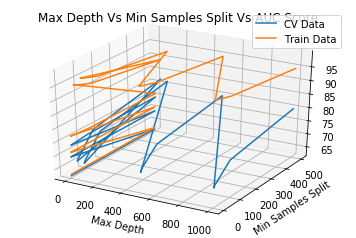

Best value of max_depth and min_samples_split is : [50, 500]


In [43]:
from sklearn.metrics import roc_auc_score
v= []
x = []
y = []
z =[]
w =[]
#best depth in range [1, 5, 10, 50, 100, 500, 100], and the best min_samples_split in range [5, 10, 100, 500]
for i in [1, 5, 10, 50, 100, 500, 1000]:
    for j in [5, 10, 100, 500]:
        clf = DecisionTreeClassifier(max_depth=i, min_samples_split=j)

        
        # fitting the model on crossvalidation train
        clf.fit(X_tr_bow, y_tr_bow)
        # predict the response on the crossvalidation train
        pred = clf.predict_proba(X_cv_bow)[:,1]
        pred2 = clf.predict_proba(X_tr_bow)[:,1]
        # evaluate CV accuracy
        acc = roc_auc_score(y_cv_bow, pred) * float(100)
        acc2 = roc_auc_score(y_tr_bow, pred2) * float(100)
        v.append([i,j])
        x.append(i)
        w.append(j)
        y.append(acc)
        z.append(acc2)

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x, w, y, label='CV Data')
ax.plot(x, w, z, label='Train Data')
ax.legend()
plt.xlabel("Max Depth")
plt.ylabel("Min Samples Split")

plt.title("Max Depth Vs Min Samples Split Vs AUC Score")
plt.show()
best = y.index(max(y))
print("Best value of max_depth and min_samples_split is :",v[best])



In [44]:
clf = DecisionTreeClassifier(max_depth=50, min_samples_split=500)
clf.fit(X_1_bow, y_1_bow)
pred = clf.predict_proba(X_test_bow)[:,1]

y_final = np.array(y_test_bow)


print("AUC Score : ",roc_auc_score(y_final,pred)*100)


#AUC Score for BOW using Decision Tree Classifier

AUC Score :  83.38004742638606


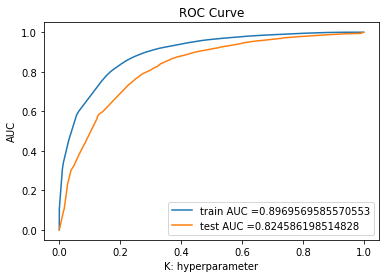

In [45]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc

clf = DecisionTreeClassifier(max_depth=50, min_samples_split=500)

    # fitting the model on crossvalidation train
clf.fit(X_tr_bow, y_tr_bow)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_bow, clf.predict_proba(X_tr_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_bow, clf.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



[[ 4134  3797]
 [ 1633 39436]]


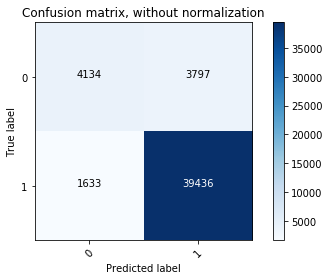

In [46]:
# Confusion matrix - train data, code is from SKLearn library
from sklearn.metrics import confusion_matrix
import itertools

class_names = ['0','1']


y_pred = clf.predict(X_tr_bow)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_tr_bow, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

[[ 1939  2896]
 [ 1427 23738]]


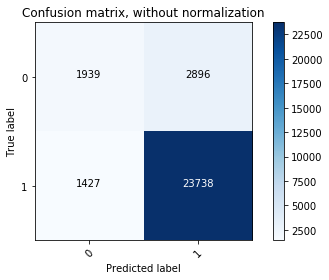

In [47]:
# Confusion matrix - test data, code is from SKLearn library
from sklearn.metrics import confusion_matrix
import itertools

class_names = ['0','1']


y_pred = clf.predict(X_test_bow)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_bow, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [48]:
top_imp_coefficients = np.argsort(clf.feature_importances_)[-20:]
print(np.take(count_vect.get_feature_names(), top_imp_coefficients))

['disappointing' 'nice' 'loves' 'perfect' 'threw' 'love' 'delicious'
 'waste' 'bad' 'awful' 'good' 'terrible' 'return' 'best' 'horrible'
 'money' 'worst' 'disappointed' 'great' 'not']


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

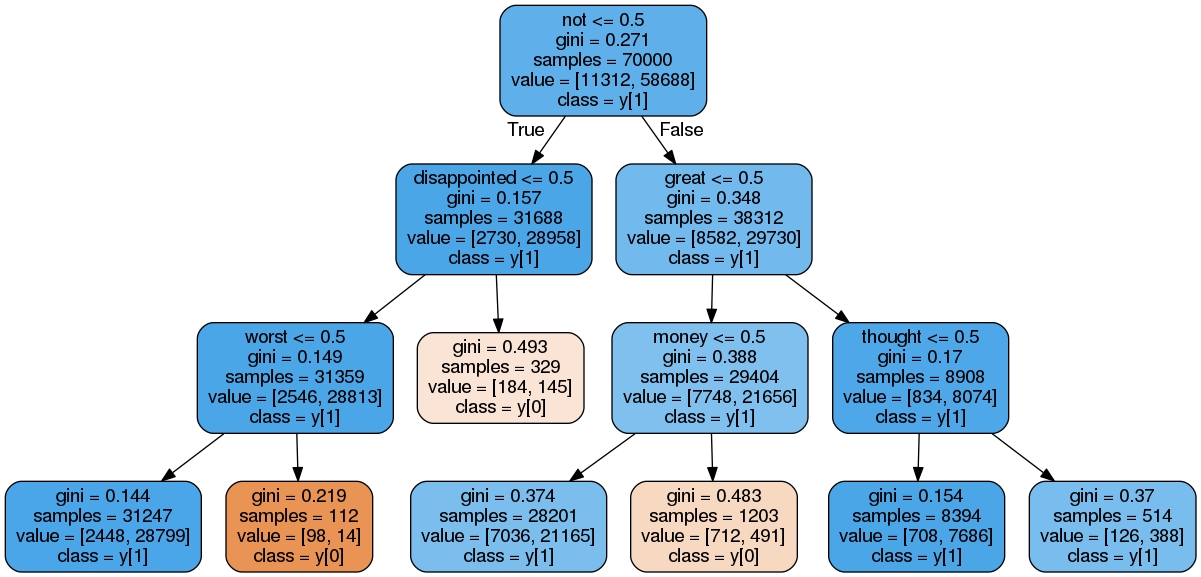

In [49]:
import collections,pydotplus
from PIL import Image
clf.max_depth=3
clf.fit(X_1_bow, y_1_bow)
od = collections.OrderedDict(sorted(count_vect.vocabulary_.items()))
dot_data = export_graphviz(clf,filled=True,rounded=True,feature_names=list(od.keys()),class_names=True)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('tree.png')
Image.open('tree.png')


## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

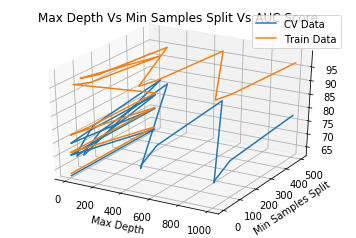

Best value of max_depth and min_samples_split is : [50, 500]


In [50]:
from sklearn.metrics import roc_auc_score
v= []
x = []
y = []
z =[]
w =[]
#best depth in range [1, 5, 10, 50, 100, 500, 100], and the best min_samples_split in range [5, 10, 100, 500]
for i in [1, 5, 10, 50, 100, 500, 1000]:
    for j in [5, 10, 100, 500]:
        clf = DecisionTreeClassifier(max_depth=i, min_samples_split=j)

        
        # fitting the model on crossvalidation train
        clf.fit(X_tr_tfidv, y_tr_tfidv)
    # predict the response on the crossvalidation train
        pred =clf.predict_proba(X_cv_tfidv)[:,1]
        pred2 = clf.predict_proba(X_tr_tfidv)[:,1]
    # evaluate CV accuracy
        acc = roc_auc_score(y_cv_tfidv, pred) * float(100)
        acc2 = roc_auc_score(y_tr_tfidv, pred2) * float(100)
        v.append([i,j])
        x.append(i)
        w.append(j)
        y.append(acc)
        z.append(acc2)

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x, w, y, label='CV Data')
ax.plot(x, w, z, label='Train Data')
ax.legend()
plt.xlabel("Max Depth")
plt.ylabel("Min Samples Split")

plt.title("Max Depth Vs Min Samples Split Vs AUC Score")
plt.show()
best = y.index(max(y))
print("Best value of max_depth and min_samples_split is :",v[best])



In [51]:

clf = DecisionTreeClassifier(max_depth=50, min_samples_split=500)
clf.fit(X_1_tfidv, y_1_tfidv)
pred = clf.predict(X_test_tfidv)

y_final = np.array(y_test_tfidv)


print("AUC Score : ",roc_auc_score(y_final,pred)*100)


#accuray for TFIDF using Decision Tree Classifier

AUC Score :  70.43175640565443


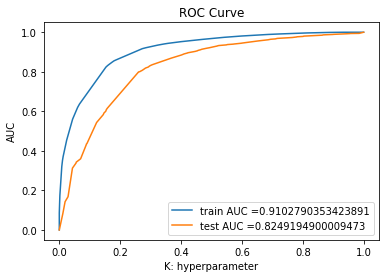

In [52]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc

clf = DecisionTreeClassifier(max_depth=50, min_samples_split=500)

    # fitting the model on crossvalidation train
clf.fit(X_tr_tfidv, y_tr_tfidv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_tfidv, clf.predict_proba(X_tr_tfidv)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_tfidv, clf.predict_proba(X_test_tfidv)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



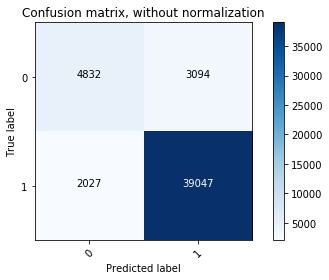

<Figure size 432x288 with 0 Axes>

In [53]:
# Confusion matrix - train data, code is from SKLearn library
from sklearn.metrics import confusion_matrix
import itertools

class_names = ['0','1']

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

y_pred = clf.predict(X_tr_tfidv)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_tr_tfidv, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

plt.show()

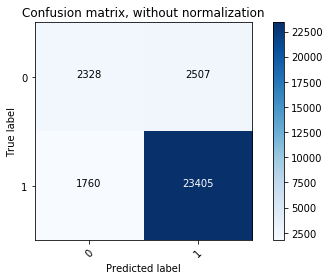

<Figure size 432x288 with 0 Axes>

In [54]:
# Confusion matrix - test data, code is from SKLearn library
from sklearn.metrics import confusion_matrix
import itertools

class_names = ['0','1']

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results

y_pred = clf.predict(X_test_tfidv)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_tfidv, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [55]:
top_imp_coefficients = np.argsort(clf.feature_importances_)[-20:]
print(np.take(tf_idf_vect.get_feature_names(), top_imp_coefficients))

['not good' 'return' 'love' 'best' 'disappointing' 'bad' 'threw'
 'delicious' 'good' 'terrible' 'awful' 'horrible' 'not recommend'
 'not disappointed' 'not buy' 'worst' 'money' 'disappointed' 'great' 'not']


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

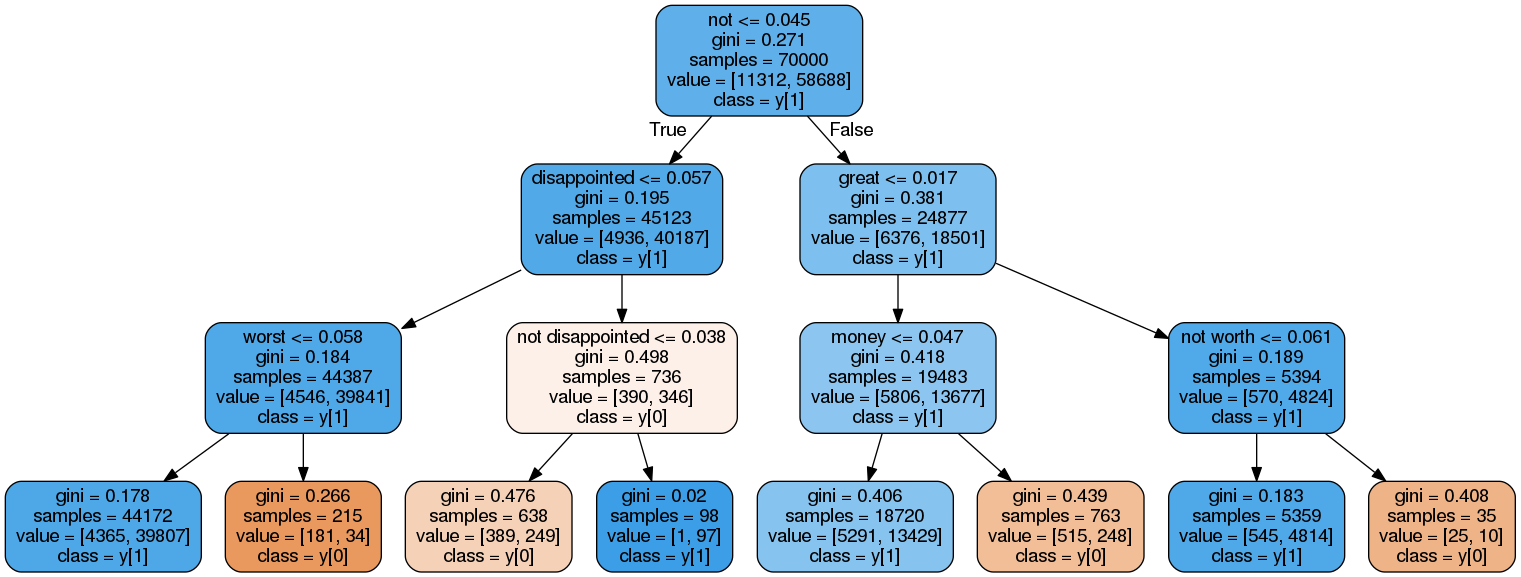

In [56]:
import collections,pydotplus
from PIL import Image
clf.max_depth=3
clf.fit(X_1_tfidv, y_1_tfidv)
od = collections.OrderedDict(sorted(tf_idf_vect.vocabulary_.items()))
dot_data = export_graphviz(clf,filled=True,rounded=True,feature_names=list(od.keys()),class_names=True)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('tree.png')
Image.open('tree.png')


## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

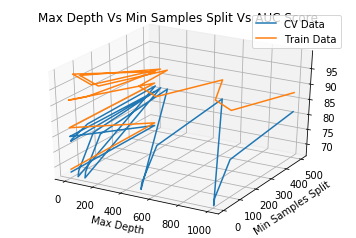

Best value of max_depth and min_samples_split is : [10, 500]


In [57]:

from sklearn.metrics import roc_auc_score
v= []
x = []
y = []
z =[]
w =[]
#best depth in range [1, 5, 10, 50, 100, 500, 100], and the best min_samples_split in range [5, 10, 100, 500]
for i in [1, 5, 10, 50, 100, 500, 1000]:
    for j in [5, 10, 100, 500]:
        clf = DecisionTreeClassifier(max_depth=i, min_samples_split=j)
        clf.fit(sent_vectors_tr, y_tr_w2v)
    # predict the response on the crossvalidation train
        pred = clf.predict_proba(sent_vectors_cv)[:,1]
        pred2 = clf.predict_proba(sent_vectors_tr)[:,1]
    # evaluate CV accuracy
        acc = roc_auc_score(y_cv_w2v, pred) * float(100)
        acc2 = roc_auc_score(y_tr_w2v, pred2) * float(100)
        v.append([i,j])
        x.append(i)
        w.append(j)
        y.append(acc)
        z.append(acc2)

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x, w, y, label='CV Data')
ax.plot(x, w, z, label='Train Data')
ax.legend()
plt.xlabel("Max Depth")
plt.ylabel("Min Samples Split")

plt.title("Max Depth Vs Min Samples Split Vs AUC Score")
plt.show()
best = y.index(max(y))
print("Best value of max_depth and min_samples_split is :",v[best])



In [58]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=500)
clf.fit(sent_vectors_1, y_1_w2v)
pred = clf.predict_proba(sent_vectors_test)[:,1]

y_final = np.array(y_test_w2v)


print("AUC Score : ",roc_auc_score(y_final,pred)*100)


#accuray for AVG-W2V using Decision Tree Classifier.

AUC Score :  82.57191265671389


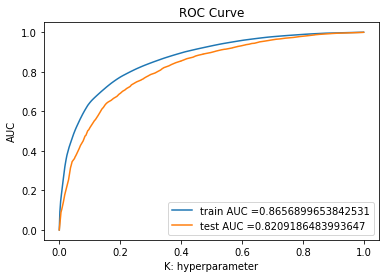

In [59]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc

clf = DecisionTreeClassifier(max_depth=10, min_samples_split=500)

    # fitting the model on crossvalidation train
clf.fit(sent_vectors_tr, y_tr_w2v)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_w2v, clf.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_w2v, clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



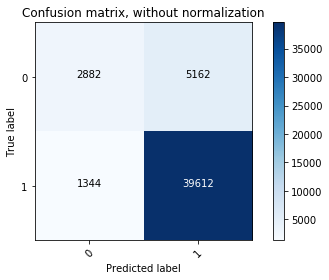

<Figure size 432x288 with 0 Axes>

In [60]:
# Confusion matrix - train data , code is from SKLearn library
from sklearn.metrics import confusion_matrix
import itertools

class_names = ['0','1']

y_pred = clf.predict(sent_vectors_tr)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_tr_w2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

plt.show()

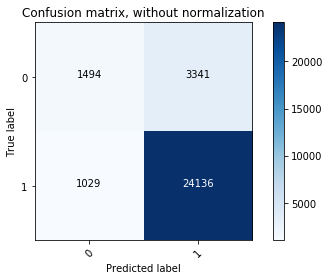

<Figure size 432x288 with 0 Axes>

In [61]:
# Confusion matrix - test data , code is from SKLearn library
from sklearn.metrics import confusion_matrix
import itertools

class_names = ['0','1']

y_pred = clf.predict(sent_vectors_test)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_w2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

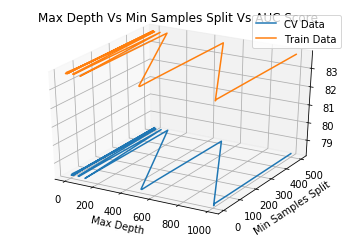

Best value of max_depth and min_samples_split is : [10, 100]


In [62]:
from sklearn.metrics import roc_auc_score
v= []
x = []
y = []
z =[]
w =[]
#best depth in range [1, 5, 10, 50, 100, 500, 100], and the best min_samples_split in range [5, 10, 100, 500]
for i in [1, 5, 10, 50, 100, 500, 1000]:
    for j in [5, 10, 100, 500]:
        clf.fit(tfidf_sent_vectors_tr, y_tr_w2v)

    # predict the response on the crossvalidation train
        pred = clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
        pred2 = clf.predict_proba(tfidf_sent_vectors_tr)[:,1]
    # evaluate CV accuracy
        acc = roc_auc_score(y_cv_w2v, pred) * float(100)
        acc2 = roc_auc_score(y_tr_w2v, pred2) * float(100)
        v.append([i,j])
        x.append(i)
        w.append(j)
        y.append(acc)
        z.append(acc2)

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x, w, y, label='CV Data')
ax.plot(x, w, z, label='Train Data')
ax.legend()
plt.xlabel("Max Depth")
plt.ylabel("Min Samples Split")

plt.title("Max Depth Vs Min Samples Split Vs AUC Score")
plt.show()
best = y.index(max(y))
print("Best value of max_depth and min_samples_split is :",v[best])



In [63]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=100)
clf.fit(tfidf_sent_vectors_1, y_1_w2v)

pred = clf.predict_proba(tfidf_sent_vectors_test)[:,1]

y_final = np.array(y_test_w2v)


print("AUC Score : ",roc_auc_score(y_final,pred)*100)
#accuray for TFIDF-W2V using Decision Tree Classifier.

AUC Score :  79.60088524322717


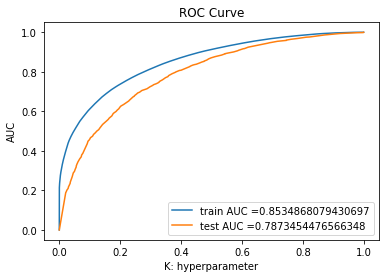

In [64]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc

clf = DecisionTreeClassifier(max_depth=100, min_samples_split=100)

    # fitting the model on crossvalidation train
clf.fit(tfidf_sent_vectors_tr, y_tr_w2v)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_w2v, clf.predict_proba(tfidf_sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_w2v, clf.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



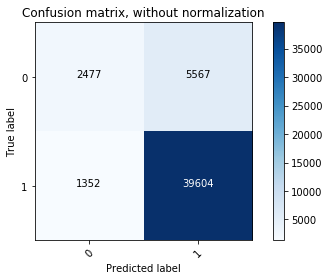

<Figure size 432x288 with 0 Axes>

In [65]:
# Confusion matrix - train data, code is from SKLearn library
from sklearn.metrics import confusion_matrix
import itertools

class_names = ['0','1']

y_pred = clf.predict(tfidf_sent_vectors_tr)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_tr_w2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

plt.show()

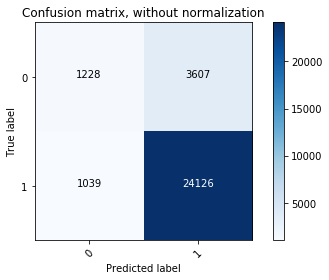

<Figure size 432x288 with 0 Axes>

In [66]:
# Confusion matrix - test data, code is from SKLearn library
from sklearn.metrics import confusion_matrix
import itertools

class_names = ['0','1']

y_pred = clf.predict(tfidf_sent_vectors_test)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_w2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()

plt.show()

# [6] Conclusions

In [67]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectoriser", "Model", "Hyperparameter ", "Accuracy"]

x.add_row(["BOW","Decision Tree",[50,500],83.38])
x.add_row(["TFIDF","Decision Tree",[50,500],70.43])
x.add_row(["W2V","Decision Tree",[10,500],82.57])
x.add_row(["TFIDF-W2V","Decision Tree",[10,100],79.60])

print(x)

+------------+---------------+-----------------+----------+
| Vectoriser |     Model     | Hyperparameter  | Accuracy |
+------------+---------------+-----------------+----------+
|    BOW     | Decision Tree |    [50, 500]    |  83.38   |
|   TFIDF    | Decision Tree |    [50, 500]    |  70.43   |
|    W2V     | Decision Tree |    [10, 500]    |  82.57   |
| TFIDF-W2V  | Decision Tree |    [10, 100]    |   79.6   |
+------------+---------------+-----------------+----------+
